Illustrate some properties of random matrices mentioned in [https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.114.088101] by Johnatan Aljadeff, Merav Stern, and Tatyana Sharpee

In [195]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.stats import beta

In [196]:
def generate_proportions(D):
    min_value = 1 / (2 * D)
    
    while True:
        points = np.sort(np.random.rand(D - 1))        
        points = np.concatenate(([0], points, [1]))        
        proportions = np.diff(points)        
        if np.all(proportions > min_value):
            return proportions

def generate_matrix(N, D, proportion, method, meanrange, covrange, gsetup):
    """
    N: number of neurons
    D: number of cell classes
    proportion (optional): cell class proportion specficity
    method: random or uniform division
    meanrange: range of block mean
    covrange: range of block covariance
    gsetup: range of block covaraince specficity
    """
    matrix = np.zeros((N, N))
    g_matrix = np.zeros((D, D))
    s_matrix = np.zeros((D, D))
    
    if method == 'uniform':
        block_size = N // D
        row_proportions = [1/D for _ in range(D)]
        for i in range(D):
            for j in range(D):
                mean = np.random.uniform(meanrange[0]**2, meanrange[1]**2)
                # not technically random but using provided proportion for testing
                if isinstance(gsetup, list):
                    gsetuparray = np.array(gsetup)
                    g = np.random.uniform(gsetuparray[i,j], gsetuparray[i,j])
                else:
                    g = np.random.uniform(covrange[0], covrange[1])

                g_matrix[i,j] = g # g_{c_i d_j}
                g /= N # standardize

                block_shape = (row_end - row_start, col_end - col_start, 2)
                block_values = np.random.normal(loc=mean, scale=np.sqrt(g), size=block_shape)

                matrix[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block_values[:, :, 0]

    elif method == 'random':
        # not technically random but using provided proportion for testing
        if isinstance(proportion, list):
            row_proportions = np.array(proportion)
        else:
            # row_proportions = np.diff(np.sort(np.concatenate(([0], np.random.rand(D - 1), [1]))))
            row_proportions = generate_proportions(D)
            assert np.isclose(np.sum(row_proportions), 1)

        col_proportions = row_proportions
        
        row_sizes = np.round(row_proportions * N).astype(int)
        col_sizes = np.round(col_proportions * N).astype(int)
        
        row_sizes[-1] += N - np.sum(row_sizes)
        col_sizes[-1] += N - np.sum(col_sizes)
        
        row_start = 0
        row_record = []
        for i in range(D):
            row_end = row_start + row_sizes[i]
            row_record.append(row_end)
            col_start = 0
            for j in range(D):
                col_end = col_start + col_sizes[j]
                mean = np.random.uniform(meanrange[0], meanrange[1])
                if isinstance(gsetup, list):
                    gsetuparray = np.array(gsetup)
                    g = np.random.uniform(gsetuparray[i,j]**2, gsetuparray[i,j]**2)
                else:
                    g = np.random.uniform(covrange[0], covrange[1])
                g_matrix[i,j] = g # g_{c_i d_j}
                g_new = g**2 / N # standardize
                
                block_shape = (row_end - row_start, col_end - col_start)

                # sample connectivity
                distname = "gaussian"

                if distname == "gaussian":
                    block_values = np.random.normal(loc=mean, scale=np.sqrt(g_new), size=block_shape)

                # sample sparsity
                s_cd = np.random.normal(loc=0.5, scale=np.sqrt(g_new))
                s_matrix[i,j] = s_cd
                bernoulli_samples = np.random.binomial(n=1, p=s_cd, size=block_shape)

                matrix[row_start:row_end, col_start:col_end] = block_values * bernoulli_samples
                # matrix[row_start:row_end, col_start:col_end] = np.array(sampled_val).reshape(block_shape)
                col_start = col_end
            row_start = row_end
    else:
        raise ValueError("Method must be 'uniform' or 'random'")
    
    # mean synaptic gain (P2 top left)
    g_bar = 0
    for i in range(D):
        for j in range(D):
            g_bar += row_proportions[i] * col_proportions[j] * (g_matrix[i,j] ** 2)
    g_bar = np.sqrt(g_bar)

    M = np.zeros((D,D))
    for i in range(D):
        for j in range(D):
            M[i,j] = col_proportions[j] * s_matrix[i,j] * (g_matrix[i,j] ** 2)

    return matrix, g_matrix, s_matrix, g_bar, M, row_record

128
256
512
1024
2048


TypeError: cannot unpack non-iterable Axes object

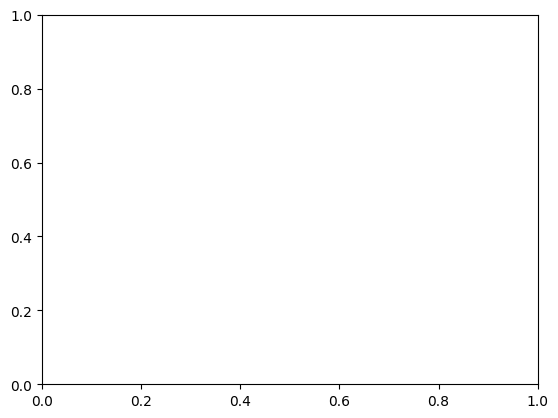

In [206]:
Nlst = [128,256,512,1024,2048]
cclst = []
for N in Nlst:
    D = 2

    cc = 0
    repeat = 10

    for _ in range(repeat):
        matrix, g_matrix, s_matrix, g_bar, M, row_record = generate_matrix(N, D, proportion=None, method='random', meanrange=[0,0], covrange=[0,2], gsetup=None)
        row_record.insert(0,0)

        # matrix = matrix / np.sum(np.abs(matrix), axis=1)
        # M = M / np.sum(np.abs(M), axis=1)

        eigenvalues = np.linalg.eigvals(matrix)
        max_real_index = np.argmax(eigenvalues.real)
        largest_eigenvalue = eigenvalues[max_real_index] 

        lambda_M = np.linalg.eigvals(M)
        max_real_index_M = np.argmax(lambda_M.real)
        kappa1 = lambda_M[max_real_index_M] 

        check = largest_eigenvalue < np.sqrt(kappa1) # whether the theory works
        cc += check
    
    cclst.append(cc/repeat)

figiter, axsiter = plt.subplots()
axsiter.plot(Nlst, cclst)

/opt/homebrew/Caskroom/miniforge/base/envs/uwzihan/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


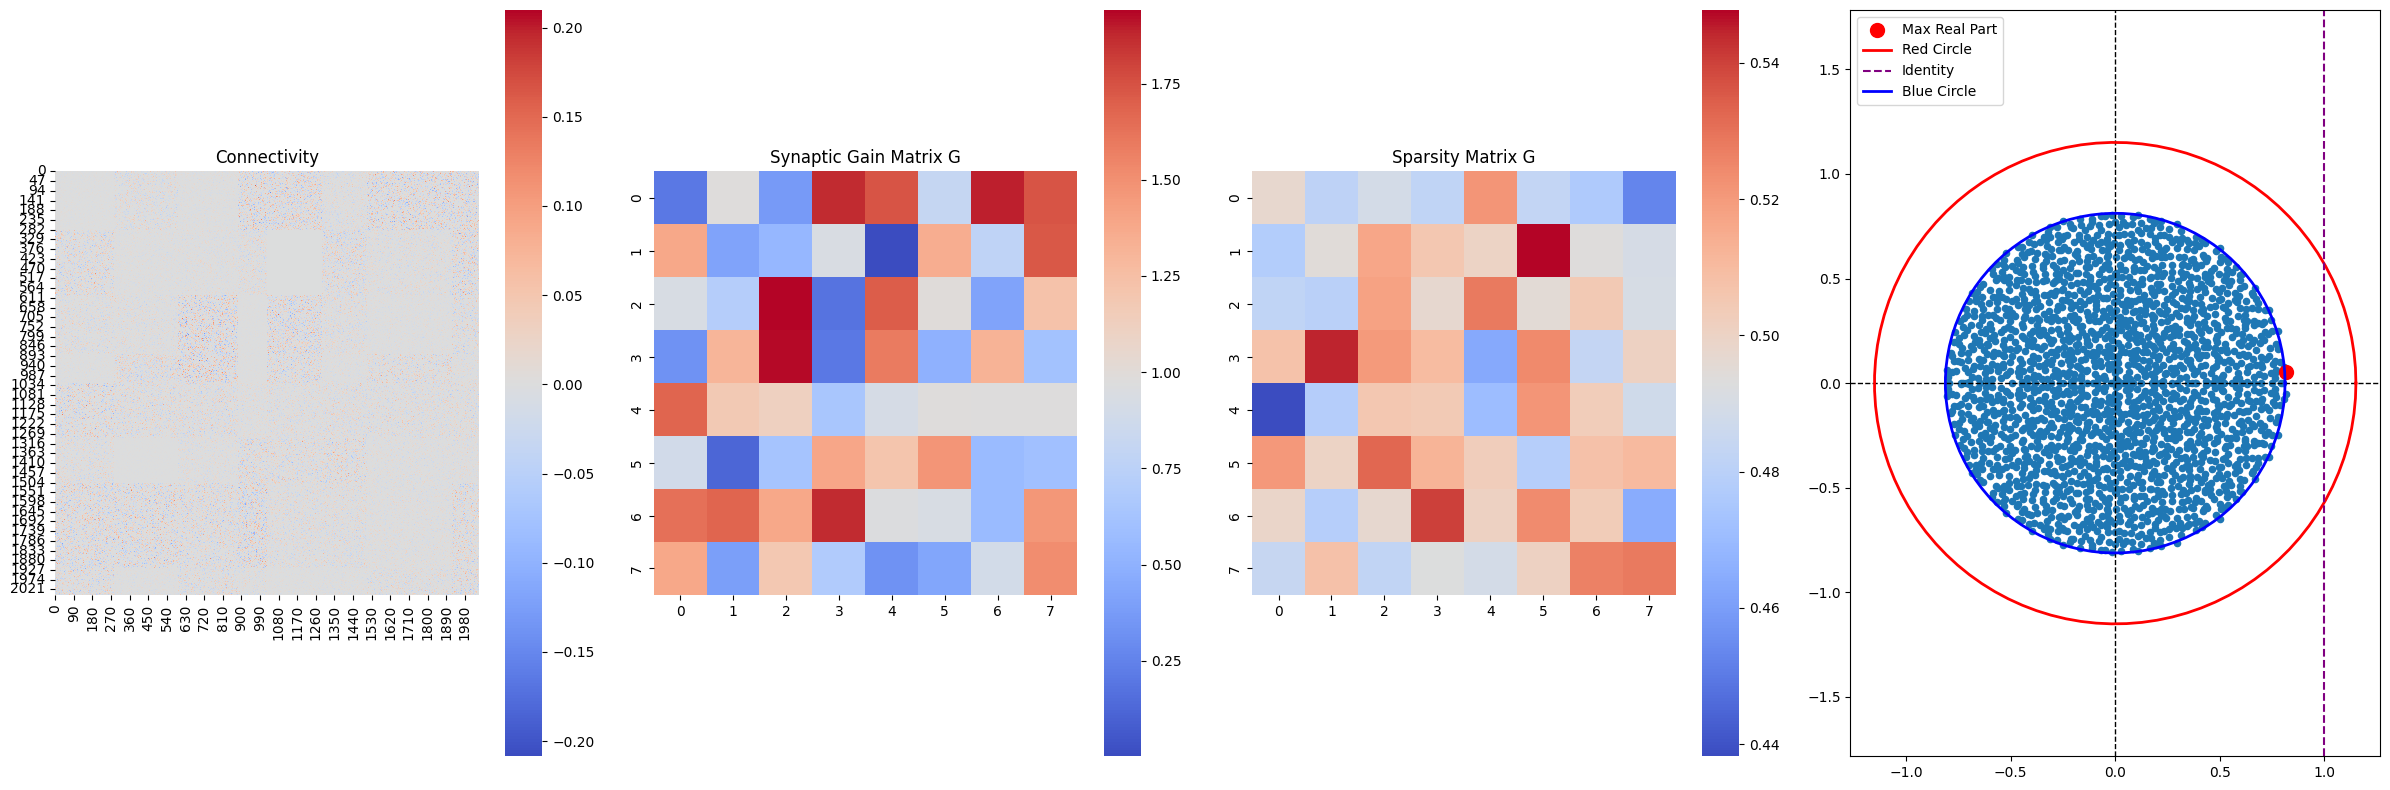

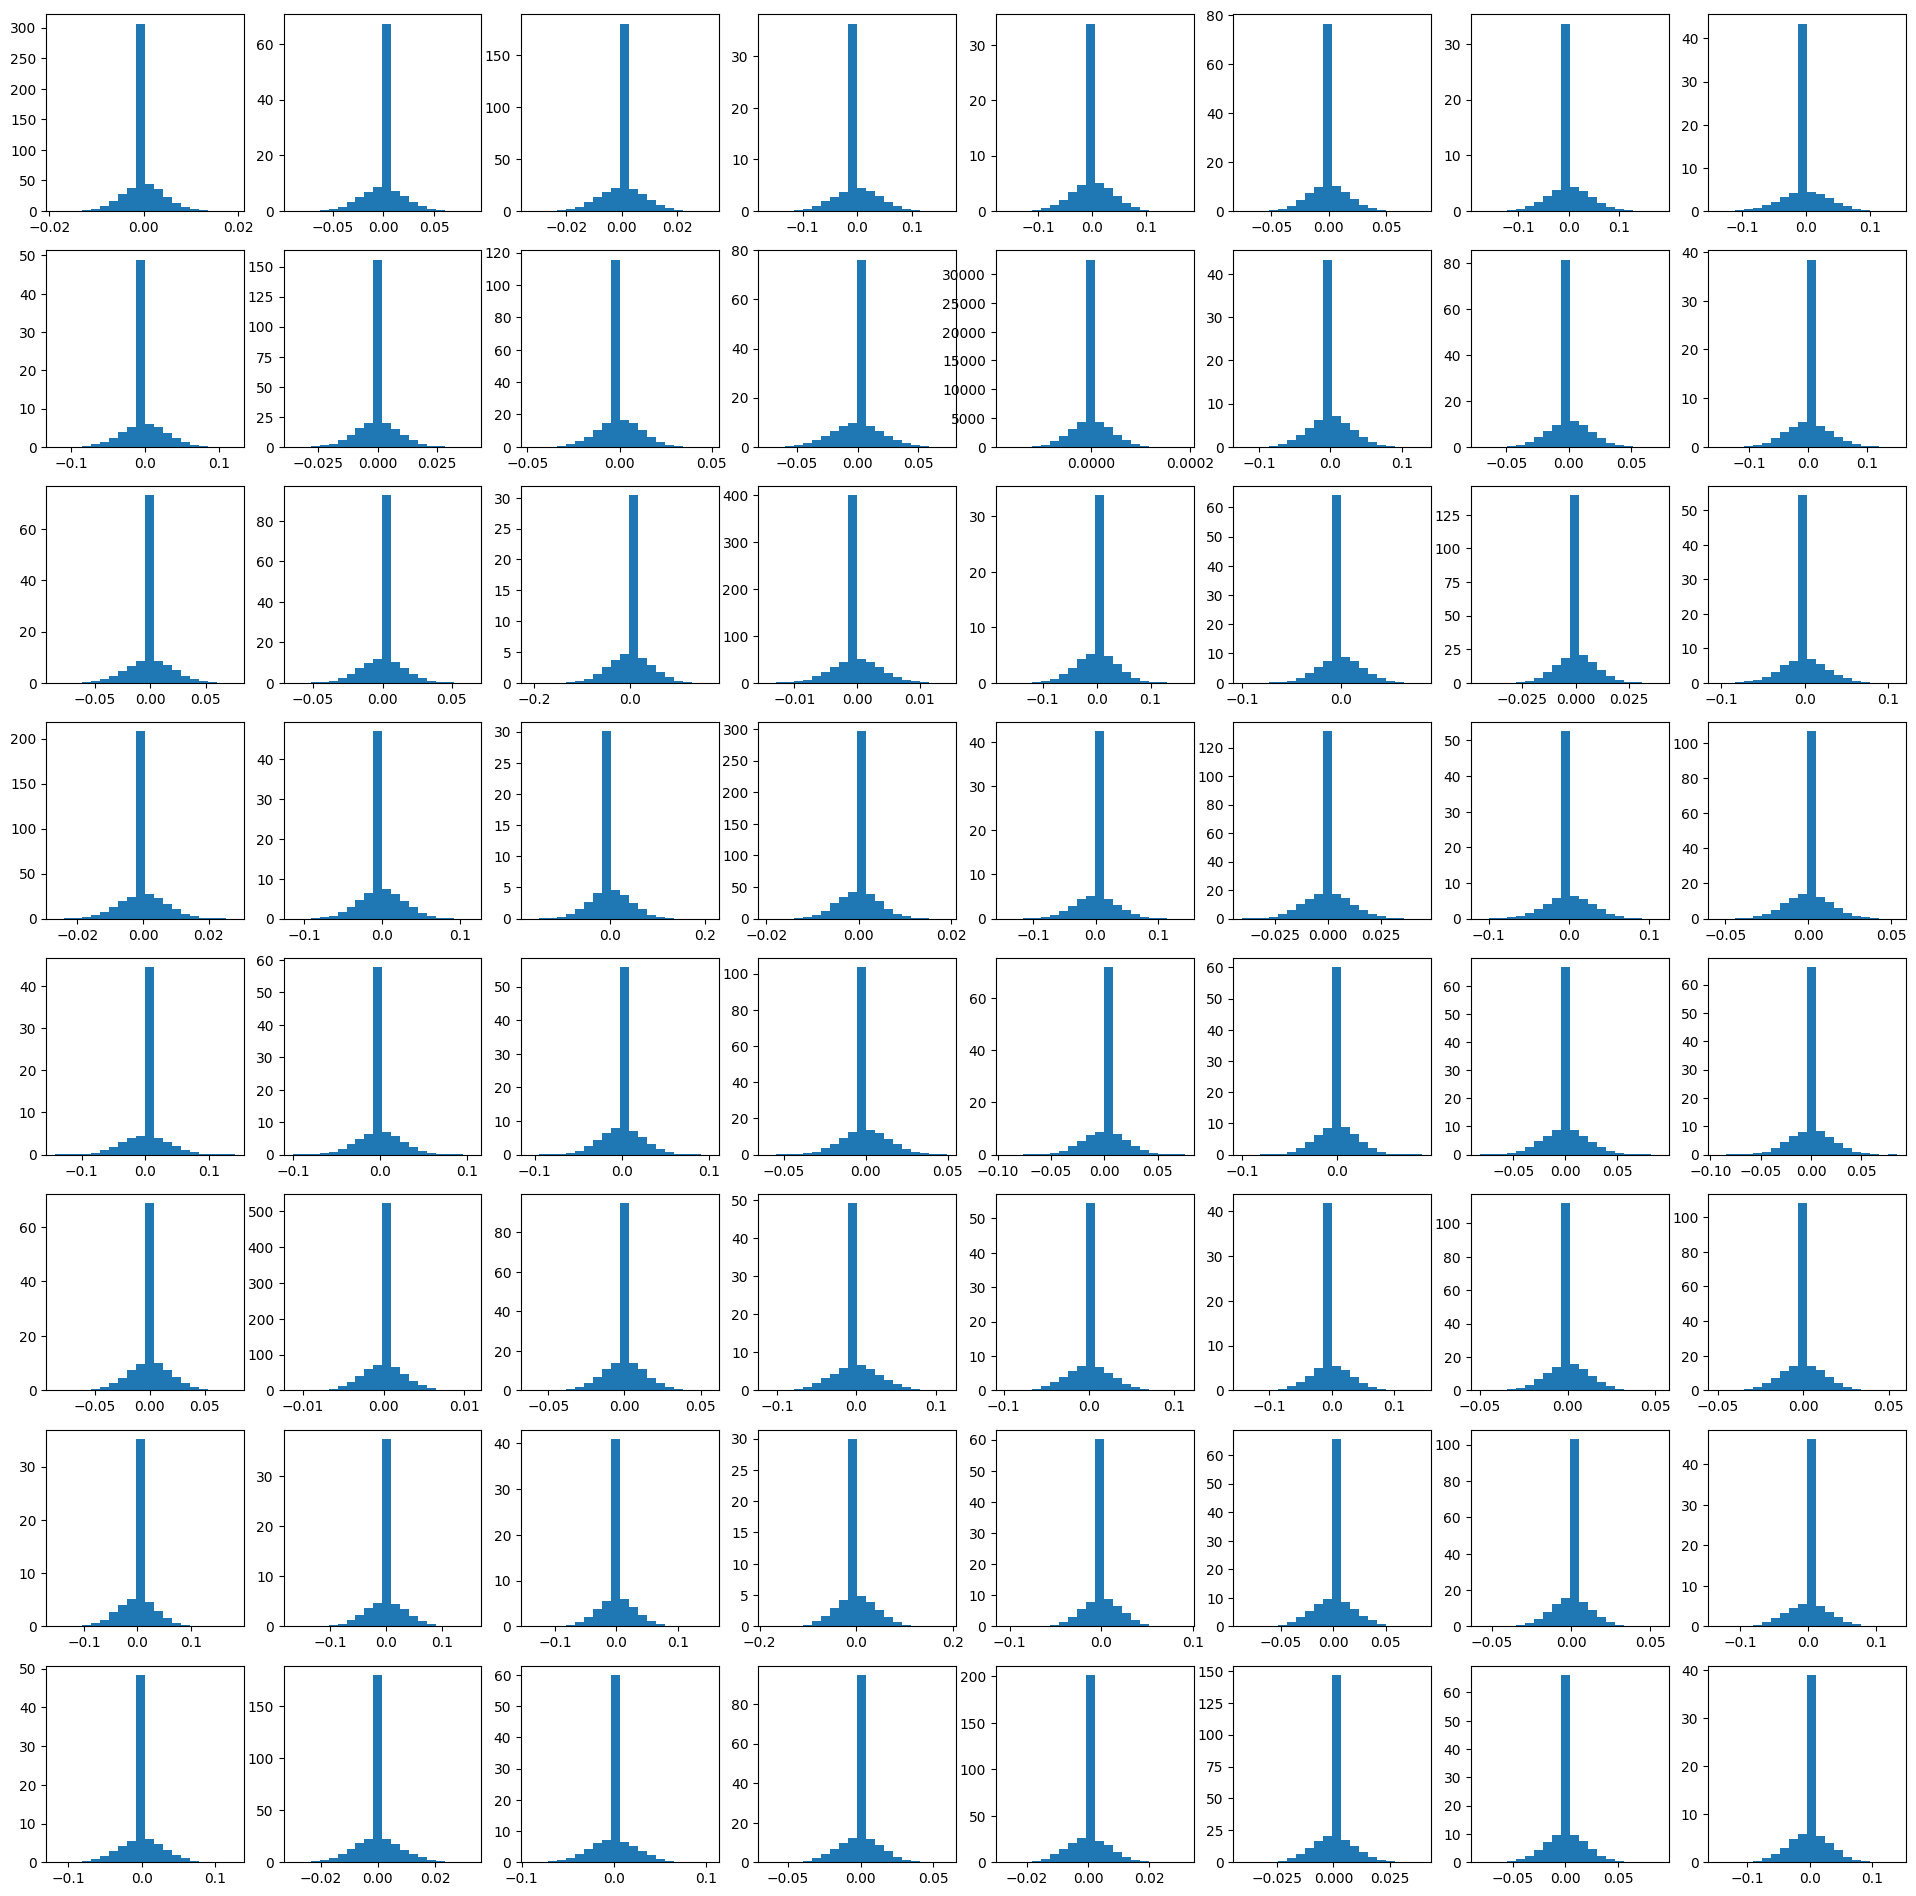

In [209]:
fig, axs = plt.subplots(1,4,figsize=(8*3,8*1))
sns.heatmap(matrix, ax=axs[0], square=True, cbar=True, cmap="coolwarm", center=0)
axs[0].set_title("Connectivity")
sns.heatmap(g_matrix, ax=axs[1], square=True, cbar=True, cmap="coolwarm")
axs[1].set_title("Synaptic Gain Matrix G")
sns.heatmap(s_matrix, ax=axs[2], square=True, cbar=True, cmap="coolwarm")
axs[2].set_title("Sparsity Matrix G")

axs[3].scatter(eigenvalues.real, eigenvalues.imag, s=20)
axs[3].scatter(eigenvalues.real[max_real_index], eigenvalues.imag[max_real_index], s=100, color='red', label='Max Real Part')
axs[3].axis("equal")
axs[3].axhline(0, color='black', linewidth=1, linestyle='--')  
axs[3].axvline(0, color='black', linewidth=1, linestyle='--')

theta = np.linspace(0, 2*np.pi, 100)

x = np.cos(theta) * g_bar
y = np.sin(theta) * g_bar
axs[3].plot(x, y, color='red', linewidth=2, label='Red Circle')
axs[3].axvline(x=1, color='purple', linestyle='--', label='Identity')
axs[3].legend()

x = np.cos(theta) * np.sqrt(kappa1)
y = np.sin(theta) * np.sqrt(kappa1)
axs[3].plot(x, y, color='blue', linewidth=2, label='Blue Circle')
axs[3].legend()
fig.tight_layout()

figdist, axsdist = plt.subplots(D, D, figsize=(3*D, 3*D))
for D1 in range(D):
    for D2 in range(D):
        matrix_cut = matrix[row_record[D1]:row_record[D1+1],row_record[D2]:row_record[D2+1]]
        axsdist[D1,D2].hist(matrix_cut.flatten(), density=True, bins=20)

plt.show()